In [1]:
from shallowmind.src.model import ModelInterface
from shallowmind.src.data import DataInterface
from shallowmind.api.infer import prepare_inference
import pandas as pd
import torch
from tqdm import tqdm
import pickle

ckpt = '/home/xiaowjia/data/Friends_fNIRS/work_dir/AFTF-ds=PictureClass_l-d=1-nh=19-r=10-bs=128-ls=0.015-label=hand/ckpts/exp_name=AFTF-ds=PictureClass_l-d=1-nh=19-r=10-bs=128-ls=0.015-label=hand-cfg=FuzzyTramsformer_ALL_num_rules10_num_heads19_dataset_name=PictureClass_label=hand_base_lr=1.5e-2_depth=1_batch_size=128-bs=128-seed=42-val_f1_score=0.7414.ckpt'
config = '/home/xiaowjia/data/Friends_fNIRS/work_dir/AFTF-ds=PictureClass_l-d=1-nh=19-r=10-bs=128-ls=0.015-label=hand/FuzzyTramsformer_ALL_num_rules10_num_heads19_dataset_name=PictureClass_label=hand_base_lr=1.5e-2_depth=1_batch_size=128.py'


data_module, model = prepare_inference(config, ckpt)
data_module.setup()
test_loader = data_module.test_dataloader()
data_table = test_loader.dataset.data_table
model = model.eval()

comet_ml is installed but `COMET_API_KEY` is not set.


The pipeline is not setup, will use identity transform
The pipeline is not setup, will use identity transform
The pipeline is not setup, will use identity transform
The pipeline is not setup, will use identity transform


In [2]:
# use cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
embeddings = {}
data_table = test_loader.dataset.data_index_table
for irow, row in tqdm(data_table.iterrows(), total=len(data_table)):
    hand = row['hand']
    relationship_label = row['relationship_label']
    emotion_label = row['emotion_label']
    pair_idx = row['pair_idx']
    subj_id = f"{emotion_label}_{pair_idx}"
    data = {'seq': []}
    trial_idxes1 = int(row['trial_idxes1'])
    trial_idxes2 = int(row['trial_idxes2'])
    d = test_loader.dataset.__getitem__(irow)
    # data['seq'] = torch.stack(data['seq'])
    with torch.no_grad():
        latent = model.model.forward_encoder(d[0]['seq'].to(device)).cpu().numpy()
        # latent = model.model.cl_projector(latent)
    embeddings.setdefault(hand, {}).setdefault(relationship_label, {}).setdefault(emotion_label, {}).setdefault(pair_idx, {}).setdefault(subj_id, []).append(latent)

with open('../output/embeddings2.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

100%|██████████| 8168/8168 [01:16<00:00, 107.03it/s]


In [3]:
#calculate Euclidean distance
import numpy as np
# embeddings = pickle.load(open('embeddings.pkl', 'rb'))

def dist(a, b):
    # return np.linalg.norm(a-b)
    # cosine distance
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# embedding_dist = []
# for hand, hand_dict in embeddings.items():
#     for relationship_label, relationship_dict in hand_dict.items():
#         for emotion_label, emotion_dict in relationship_dict.items():
#             for pair_idx, pair_dict in tqdm(emotion_dict.items(), total=len(emotion_dict), desc=f'{hand}-{relationship_label}-{emotion_label}'):
                
#                 distance_matrix = np.zeros((len(pair_dict[0][0]), len(pair_dict[1][0])))
#                 for i, e1 in enumerate(pair_dict[0][0]):
#                     for j, e2 in enumerate(pair_dict[1][0]):
#                         distance_matrix[i,j] = dist(e1, e2)
#                 avg_dist = np.mean(distance_matrix)
#                 embedding_dist.append([str(hand), str(relationship_label), str(emotion_label), str(pair_idx), avg_dist])
embedding_dist = []
for hand, hand_dict in embeddings.items():
    for relationship_label, relationship_dict in hand_dict.items():
        for emotion_label, emotion_dict in relationship_dict.items():
            for pair_idx, pair_dict in tqdm(emotion_dict.items(), total=len(emotion_dict), desc=f'{hand}-{relationship_label}-{emotion_label}'):
                
                pair_dict = np.stack(pair_dict[list(pair_dict.keys())[0]])
                distance_matrix = np.zeros((pair_dict.shape[0], pair_dict.shape[0]))
                for i, e1 in enumerate(pair_dict):
                    for j, e2 in enumerate(pair_dict):
                        distance_matrix[i,j] = dist(e1[0], e2[1])
                avg_dist = np.mean(distance_matrix)
                embedding_dist.append([str(hand), str(relationship_label), str(emotion_label), str(pair_idx), avg_dist])
embedding_dist = pd.DataFrame(embedding_dist, columns=['hand', 'relationship_label', 'emotion_label', 'pair_idx', 'avg_dist'])


2-1-3: 100%|██████████| 13/13 [00:00<00:00, 21.11it/s]


In [4]:
import pingouin as pg
x = embedding_dist.loc[(embedding_dist['emotion_label']=='2') & (embedding_dist['relationship_label']=='1') & (embedding_dist['hand']=='1')]['avg_dist']
y = embedding_dist.loc[(embedding_dist['emotion_label']=='2') & (embedding_dist['relationship_label']=='1') & (embedding_dist['hand']=='2')]['avg_dist']
stat = pg.ttest(x, y)
print(stat)

               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.734829  20.458547   two-sided  0.470783  [-0.01, 0.03]  0.297528   

         BF10     power  
T-test  0.449  0.109896  


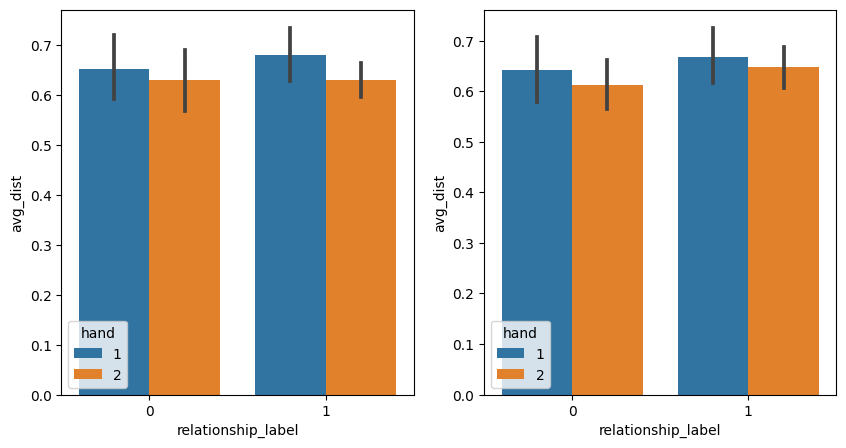

In [53]:
# stats
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# plot
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
sns.barplot(x='relationship_label', y='avg_dist', hue='hand', data=embedding_dist.loc[embedding_dist['emotion_label']=='2'], ax=ax)
ax = plt.subplot(122)
sns.barplot(x='relationship_label', y='avg_dist', hue='hand', data=embedding_dist.loc[embedding_dist['emotion_label']=='3'], ax=ax)
plt.show()


In [48]:
embedding_dist

,hand,relationship_label,emotion_label,pair_idx,avg_dist


In [ ]:
embedding_dist['subject'] = embedding_dist.apply(lambda x: f"{x['relationship_label']}_{x['pair_idx'].split('-')[-1]}", axis=1)

print(embedding_dist)

pg.mixed_anova(
    data=embedding_dist.loc[embedding_dist['emotion_label']=='2'], 
    dv='avg_dist', 
    within='hand',
    between='relationship_label',
    subject='subject',
    correction=True,
)

In [55]:
#calculate Euclidean distance
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# embeddings = pickle.load(open('embeddings.pkl', 'rb'))
np.random.seed(42)
def dist(a, b):
    # return np.linalg.norm(a-b)
    # cosine distance
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

n_samples = 2
n_repeat = 100

stats_neg = []
stats_neu = []

p_relationship_neg = []
p_hand_neg = []
p_relationship_neu = []
p_hand_neu = []
p_interaction_neg = []
p_interaction_neu = []
p_hand_in_friend_neg = []

for i_repeat in tqdm(range(n_repeat), total=n_repeat):
    embedding_dist = []
    for hand, hand_dict in embeddings.items():
        for relationship_label, relationship_dict in hand_dict.items():
            for emotion_label, emotion_dict in relationship_dict.items():
                for pair_idx, pair_dict in emotion_dict.items():
                    
                    distance_matrix = np.zeros((n_samples, n_samples))
                    random_idxes1 = np.random.choice(range(len(pair_dict[0][0])), size=n_samples, replace=False)
                    random_idxes2 = np.random.choice(range(len(pair_dict[1][0])), size=n_samples, replace=False)
                    for i, e1 in enumerate(pair_dict[0][0][random_idxes1]):
                        for j, e2 in enumerate(pair_dict[1][0][random_idxes2]):
                            distance_matrix[i,j] = dist(e1, e2)
                    avg_dist = np.mean(distance_matrix)
                    embedding_dist.append([str(hand), str(relationship_label), str(emotion_label), str(pair_idx), avg_dist])

                    
    embedding_dist = pd.DataFrame(embedding_dist, columns=['hand', 'relationship_label', 'emotion_label', 'pair_idx', 'avg_dist'])
    embedding_dist.to_csv('embedding_dist.csv', index=False)
    embedding_dist['subject'] = embedding_dist.apply(lambda x: f"{x['relationship_label']}_{x['pair_idx'].split('-')[-1]}", axis=1)
    
    stat = pg.mixed_anova(
        data=embedding_dist.loc[embedding_dist['emotion_label']=='2'], 
        dv='avg_dist', 
        within='hand',
        between='relationship_label',
        subject='subject',
        correction=True,
    )      
    
    stats_neg.append(stat)
    p_relationship_neg.append(stat['p-unc'][0])
    p_hand_neg.append(stat['p-unc'][1])
    p_interaction_neg.append(stat['p-unc'][2])

    stat = pg.mixed_anova(
        data=embedding_dist.loc[embedding_dist['emotion_label']=='3'], 
        dv='avg_dist', 
        within='hand',
        between='relationship_label',
        subject='subject',
        correction=True,
    )
    stats_neu.append(stat)
    p_relationship_neu.append(stat['p-unc'][0])
    p_hand_neu.append(stat['p-unc'][1])
    p_interaction_neu.append(stat['p-unc'][2])

    # t-test of hand in relationship-label=1
    x = embedding_dist.loc[(embedding_dist['emotion_label']=='2') & (embedding_dist['relationship_label']=='1') & (embedding_dist['hand']=='1')]['avg_dist']
    y = embedding_dist.loc[(embedding_dist['emotion_label']=='2') & (embedding_dist['relationship_label']=='1') & (embedding_dist['hand']=='2')]['avg_dist']
    stat = pg.ttest(x, y, paired=True, correction=True)
    p_hand_in_friend_neg.append(stat['p-val'])

# count how many times it is smaller than 0.05 
print("p_relationship_neg", 1-np.sum(np.array(p_relationship_neg)<0.05)/n_repeat)
print("p_hand_neg", 1-np.sum(np.array(p_hand_neg)<0.05)/n_repeat)
print("p_interaction_neg", 1-np.sum(np.array(p_interaction_neg)<0.05)/n_repeat)
print("p_relationship_neu", 1-np.sum(np.array(p_relationship_neu)<0.05)/n_repeat)
print("p_hand_neu", 1-np.sum(np.array(p_hand_neu)<0.05)/n_repeat)
print("p_interaction_neu", 1-np.sum(np.array(p_interaction_neu)<0.05)/n_repeat)
print("p_hand_in_friend_neg", 1-np.sum(np.array(p_hand_in_friend_neg)<0.05)/n_repeat)


  0%|          | 0/100 [00:00<?, ?it/s]


KeyError: 0

In [ ]:
# stats
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# plot
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(121)
sns.barplot(x='relationship_label', y='avg_dist', hue='hand', data=embedding_dist.loc[embedding_dist['emotion_label']=='2'], ax=ax)
ax = plt.subplot(122)
sns.barplot(x='relationship_label', y='avg_dist', hue='hand', data=embedding_dist.loc[embedding_dist['emotion_label']=='3'], ax=ax)
plt.show()

In [ ]:
import umap.umap_ as umap
embedding_data = []
label = []
for hand, hand_dict in embeddings.items():
    for relationship_label, relationship_dict in hand_dict.items():
        for emotion_label, emotion_dict in relationship_dict.items():
            for pair_idx, pair_dict in emotion_dict.items():
                pair_data = np.concatenate([pair_dict[0][0].numpy().mean(axis=0), pair_dict[1][0].numpy().mean(axis=0)], axis=0)
                embedding_data.append(pair_data)
                label.append(f'{hand}')
embedding_data = np.stack(embedding_data)
embedding_data = embedding_data - embedding_data.mean(axis=0)
embedding_data = embedding_data / embedding_data.std(axis=0)
reducer = umap.UMAP()
embedding = reducer.fit_transform(embedding_data)
embedding = pd.DataFrame(embedding, columns=['x', 'y'])
embedding['label'] = label

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x='x', y='y', hue='label', data=embedding)
plt.show()